In [422]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from kaggler.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

# 데이터 불러오기

In [423]:
train = pd.read_csv('./open/train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./open/test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./open/sample_submission.csv')

In [424]:
# day를 year로 변경해주는 함수
def days_to_age(x):
    return (x*-1)/365

In [425]:
# 마이너스 변환
def minus(x):
    return x * -1

# 추가 변수 생성하기

In [426]:
def add_var(data):
    
    # 개개인을 구분할 수 있는 변수들을 묶어서 생성
    data['personal_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str)
    
    # 카드를 생성한 기간도 같은 경우가 있어서 begin을 추가하여 하나의 변수를 더 생성
    data['personal_begin_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str) + "_" + data['begin_month'].apply(str)
    
    # 그외의 변수들을 조합하여 하나의 변수로 추가 생성
    data['g_r_c'] = data['gender'] + "_" + data['reality'] + "_" + data['car'] 
    data['p_w_e'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str) 
    #data['h_r_c'] = data['house_type'] + "_" + data['reality'] + "_" + data['car']
    
    return data

In [427]:
train = add_var(train)
test = add_var(test)

# 숫자형 변수 전처리 및 변수 생성

다양한 방법으로 전처리 및 변수 생성을 진행하면서 성능이 제일 잘 나온 경우로 정리하였습니다.

In [428]:
def numeric_process(data):
    
    # income_total 변수 전처리
    # 만단위로 생성
    data['income_total'] = data['income_total']/10000
    # 편차 제곱 변수 생성
    data['income_total_dev'] = (data['income_total'] - data['income_total'].mean())**2
    # 로그 변환
    data['income_total_log'] = data['income_total'].apply(np.log1p)

    # DAYS_EMPLOYED 변수 전처리
    # 로그 변환
    data['DAYS_EMPLOYED_log'] = data['DAYS_EMPLOYED'].map(lambda x: x if x < 0 else 0).apply(lambda x: np.log1p(x*-1))
    # day를 year로 변환
    # 0 이상인 경우 0으로 모두 변환
    data.loc[data['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)
    
    # begin_month 변수 전처리
    # 마이너스 변환
    data['begin_month'] = data['begin_month'].apply(minus)
    
    # DAYS_BIRTH 변수 전처리
    # day를 year로 변환
    data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)
    
    #  DAYS_BIRTH, DAYS_EMPLOYED 비율로 income 데이터 전처리
    data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
    data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
    
    # chid_num과 family_size는 다음과 같이 최대 2와 5가 되도록 전처리
    data['diff_fam_child'] = data['family_size'] - data['child_num']
    data.loc[data['child_num'] >= 2,'child_num'] = 2
    data.loc[data['family_size'] >= 5,'child_num'] = 5
    
    # 가족수와 자녀수 sum
    data['FAM_CHILD_SUM'] = data[['child_num', 'family_size']].sum(axis=1)
    
    # income을 가족 수로 나눈 비율
    data['INCOME_FAM_RATIO'] = data['income_total']/data['family_size']
    data['INCOME_child_num_RATIO'] = data['income_total']/data['child_num']
    
    # 일을하게 된 시점 변수 추가
    data['before_EMPLOYED'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    data['INCOME_before_EMPLOYED_RATIO'] = data['income_total']/data['before_EMPLOYED']
    
    return data 

In [429]:
train = numeric_process(train)
test = numeric_process(test)

In [430]:
def occype_process(data):
    
    # 경력이 없고 직업군이 none인 사람은 no_work로 대체
    data['occyp_type'] = data['occyp_type'].fillna('NAN')
    data.loc[(data['DAYS_EMPLOYED'] == 0) & (data['occyp_type'] == 'NAN'), 'occyp_type'] = 'no_work'
    print(data['occyp_type'].value_counts())
    
    return data


In [431]:
train = occype_process(train)
test = occype_process(test)

Laborers                 4512
no_work                  4438
NAN                      3733
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64
Laborers                 1699
no_work                  1697
NAN                      1455
Sales staff               946
Core staff                945
Managers                  845
Drivers                   563
Medicine staff            343
High skill tech staff     343
Accountants               339
Cooking staff             198
Security staff            168
Cleaning 

In [432]:
#구간화 함수
def make_bin(df, variable, n):
    
    data = df
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable] = pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]
    
    return data

In [ ]:
# days_birth만 구간화 했을 떄 가장 성능이 좋았음

train = make_bin(train, 'DAYS_BIRTH', n=10)
# make_bin(train, 'income_total_log', n=25)
# make_bin(train, 'DAYS_EMPLOYED_log', n=15)
#make_bin(train, 'begin_month', n=6)
test = make_bin(test, 'DAYS_BIRTH', n=10)
# make_bin(test, 'income_total_log', n=25)
# make_bin(test, 'DAYS_EMPLOYED_log', n=15)
#make_bin(test, 'begin_month', n=6)

# 이상치 제거
효과는 없었음

In [434]:
def remove_outlier(train, column):
    
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 5
    highest = quan_75 + iqr * 5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train


In [435]:
# candidate = ['income_total', 'DAYS_EMPLOYED']
# for cand in candidate:  
#     train = remove_outlier(train,cand)

# train.reset_index(drop = True,inplace = True)
# len(train)

In [436]:
# 불필요 변수 제거
train = train.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)
test = test.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)

In [437]:
train.shape, test.shape

((26457, 33), (10000, 32))

In [438]:
train_x = train.drop(['credit'],axis=1)
train_y = train['credit']

In [439]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26457 non-null  object 
 1   car                           26457 non-null  object 
 2   reality                       26457 non-null  object 
 3   child_num                     26457 non-null  int64  
 4   income_type                   26457 non-null  object 
 5   edu_type                      26457 non-null  object 
 6   family_type                   26457 non-null  object 
 7   house_type                    26457 non-null  object 
 8   DAYS_BIRTH                    26457 non-null  float64
 9   work_phone                    26457 non-null  int64  
 10  phone                         26457 non-null  int64  
 11  email                         26457 non-null  int64  
 12  occyp_type                    26457 non-null  object 
 13  f

In [440]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in train_x.columns if train_x[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(train_x, cat_features)    
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'personal_begin_id', 'g_r_c', 'p_w_e']
[ 0  1  2  4  5  6  7 12 15 16 17 18]


# 모델 학습

In [441]:
cat_models={}

#cat_features = [0,1,2,4,5,6,7,12,15,16,17,18]
#random_seed = [1042]

def run_kfold(max_depth, learning_rate, random_seed):
    
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostClassifier(n_estimators=3000, max_depth=max_depth, random_seed=seed, learning_rate=learning_rate, bootstrap_type ='Bernoulli')
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50, cat_features=cat_features,
                  verbose=100)

            cat_models[n_fold] = cat

            predictions = cat.predict_proba(X_val)
            test_predictions = cat.predict_proba(test)

            logloss=log_loss(to_categorical(y_val), predictions)
            outcomes.append(logloss)
            print(f"FOLD {n_fold+1} : logloss:{logloss}")

            sub+= test_predictions

            print(f'================================================================================\n\n')

    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    return sub/(folds.n_splits * len(random_seed))
    


In [442]:
my_submission = run_kfold(8, 0.04, [1042])
# my_submission1 = run_kfold(8, 0.02, 40, [1042], 0.8)
# print('*********************************\n\n')
# my_submission2 = run_kfold(8, 0.039, 3, [510])
# print('*********************************\n\n')
# my_submission3 = run_kfold(8, 0.03, 20, [77], 0.9)

====================================1============================================
0:	learn: 1.0756815	test: 1.0756390	test1: 1.0760838	best: 1.0760838 (0)	total: 67.1ms	remaining: 3m 21s
100:	learn: 0.7159691	test: 0.5162796	test1: 0.6925561	best: 0.6925561 (100)	total: 11.6s	remaining: 5m 31s
200:	learn: 0.6984887	test: 0.4907799	test1: 0.6858926	best: 0.6857515 (193)	total: 26.3s	remaining: 6m 6s
300:	learn: 0.6829930	test: 0.4801303	test1: 0.6825490	best: 0.6825490 (300)	total: 42.2s	remaining: 6m 18s
400:	learn: 0.6666448	test: 0.4749608	test1: 0.6816339	best: 0.6815551 (371)	total: 58s	remaining: 6m 16s
500:	learn: 0.6519219	test: 0.4673573	test1: 0.6803795	best: 0.6803768 (499)	total: 1m 14s	remaining: 6m 10s
600:	learn: 0.6391678	test: 0.4628879	test1: 0.6795965	best: 0.6795746 (576)	total: 1m 30s	remaining: 6m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.679137477
bestIteration = 609

Shrink model to first 610 iterations.
FOLD 1 : logloss:0.67913747699525

300:	learn: 0.6855925	test: 0.4543542	test1: 0.6750077	best: 0.6750069 (298)	total: 49.1s	remaining: 7m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.674301689
bestIteration = 342

Shrink model to first 343 iterations.
FOLD 9 : logloss:0.6743016889997454


====================================10============================================
0:	learn: 1.0758219	test: 1.0758219	test1: 1.0754271	best: 1.0754271 (0)	total: 23.3ms	remaining: 1m 9s
100:	learn: 0.7169360	test: 0.5165325	test1: 0.6689324	best: 0.6689324 (100)	total: 14.4s	remaining: 6m 52s
200:	learn: 0.7007446	test: 0.4892093	test1: 0.6619072	best: 0.6619072 (200)	total: 31.5s	remaining: 7m 18s
300:	learn: 0.6853813	test: 0.4721139	test1: 0.6594700	best: 0.6594594 (299)	total: 50.2s	remaining: 7m 30s
400:	learn: 0.6707519	test: 0.4653421	test1: 0.6584098	best: 0.6583634 (365)	total: 1m 9s	remaining: 7m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6576187861
bestIteration = 444

# Feature_Importance_Plot

In [443]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


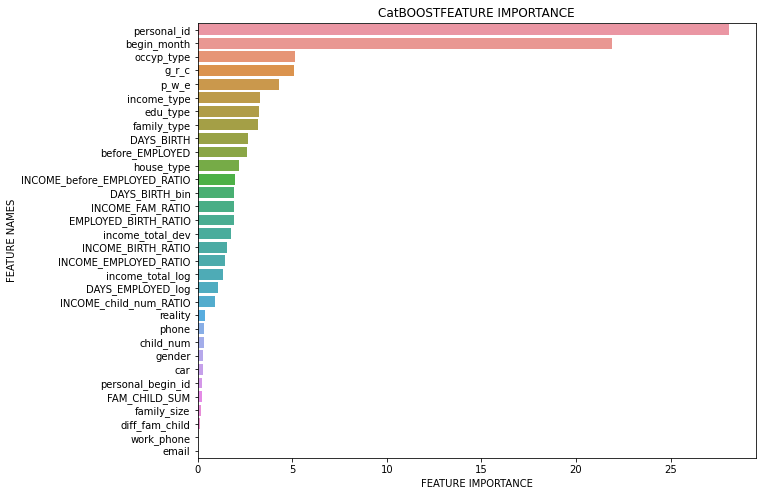

In [444]:
#plot the xgboost result
plot_feature_importance(cat_models[0].get_feature_importance(), train_x.columns,'CatBOOST')

# 결과 확인 및 제출 파일 생성

In [445]:
my_submission

array([[0.1275502 , 0.16075725, 0.71169255],
       [0.32448877, 0.23571475, 0.43979648],
       [0.04349083, 0.07473082, 0.88177835],
       ...,
       [0.04933416, 0.11131424, 0.8393516 ],
       [0.14313305, 0.3160865 , 0.54078046],
       [0.06700099, 0.41530601, 0.51769299]])

In [446]:
# my_submission_mean = (my_submission1 + my_submission2 + my_submission3)/3
# my_submission_mean

In [447]:
submission=pd.read_csv('./open/sample_submission.csv')
submission.loc[:,1:]=my_submission
submission

,index,0,1,2
0,26457,0.127550,0.160757,0.711693
1,26458,0.324489,0.235715,0.439796
2,26459,0.043491,0.074731,0.881778
3,26460,0.063023,0.082052,0.854926
4,26461,0.080261,0.220365,0.699374
...,...,...,...,...
9995,36452,0.072378,0.237477,0.690145
9996,36453,0.132811,0.409360,0.457829
9997,36454,0.049334,0.111314,0.839352
9998,36455,0.143133,0.316086,0.540780


In [448]:
submission.to_csv('./submit/10fold_cat_0.66596.csv', index=False) # 0.7272812144

In [449]:
submission.head(20)

,index,0,1,2
0,26457,0.127550,0.160757,0.711693
1,26458,0.324489,0.235715,0.439796
2,26459,0.043491,0.074731,0.881778
3,26460,0.063023,0.082052,0.854926
4,26461,0.080261,0.220365,0.699374
5,26462,0.055474,0.126492,0.818035
6,26463,0.621339,0.351777,0.026884
7,26464,0.052347,0.090390,0.857263
8,26465,0.063257,0.092555,0.844188
9,26466,0.054782,0.278417,0.666800
